# Advanced lane finding project.
This jupyter notebook is used to find the lane lines on the road. First define the functions and test on test images. 
Then, define a pipeline to process video and test on the project_video.mp4. 


First, compute the camera matrix and distortion coefficients. 

calibration.py

In [2]:
import numpy as np
import cv2
import glob
import pickle

#Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Test undistortion on an image
img = cv2.imread('test_images/test4.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open("dist_pickle.p", "wb"))

Define the functions to do perspective transformation

perspective_transform.py

In [3]:

def compute_M_Minv():
    '''
    This is used to compute M and Minv
    :return:
    '''
    # src points x,y 280,720   1250, 720 590, 450  710, 450
    src = np.float32([[595, 460], [715, 460], [280, 720], [1260, 720]])

    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[350, 0], [950, 0], [350, 720], [950, 720]])

    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


def pt(img, M):
    '''
    This is used to apply perspective transform
    :param img:
    :param M:
    :return:
    '''
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    return warped


Define the functions to do thresholding and perspective transformation.

thresholding.py

In [4]:

import matplotlib.image as mpimg
#read the camera calibration result
with open('dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 1

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def abs_sobel_thresh(img, thresh_min=0, thresh_max=255):
    '''
    This is used to apply x gradient.
    :param img:
    :param thresh_min:
    :param thresh_max:
    :return:
    '''
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def color_mask(img):
    '''
    This is used to convert the color space to HSV, and pick yellow lane and white lane according to the color range.
    :param img:
    :return:
    '''

    dst = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    yellow_hsv_low = np.array([0, 80, 0])
    yellow_hsv_high = np.array([80, 255, 255])

    white_hsv_low = np.array([20, 0, 180])
    white_hsv_high = np.array([255, 80, 255])

    mask_yellow = cv2.inRange(dst, yellow_hsv_low, yellow_hsv_high)
    mask_white = cv2.inRange(dst, white_hsv_low, white_hsv_high)
    return mask_yellow+mask_white


def thresholding(img, M):
    '''
    This is used to combine X gradient and color selection.
    :param img:
    :return:
    '''
    #undistort
    dst = cv2.undistort(img, dist_pickle["mtx"], dist_pickle["dist"], None, dist_pickle["mtx"])

    #mpimg.imsave("output_images/undistort/test6.png", dst)

    #apply region mask
    imshape = dst.shape
    vertices = np.array([[(50, imshape[0]), (0.472 * imshape[1], 400),
                          (0.528 * imshape[1], 400),
                          (imshape[1] - 50, imshape[0])]], dtype=np.int32)
    region = region_of_interest(dst, vertices)

    #apply perspective transform
    region = pt(region, M)

    #apply color selection
    color = color_mask(region)

    #apply x gradient.
    grad_binary = abs_sobel_thresh(region, thresh_min=10, thresh_max=50)

    #use hough transform to clean the pixels found by grad_binary
    # Define the Hough transform parameters
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 30  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30  # minimum number of pixels making up a line
    max_line_gap = 0  # maximum gap in pixels between connectable line segments

    line_image = np.copy(color) * 0  # creating a blank to draw lines on

    lines = cv2.HoughLinesP(grad_binary, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), 255, thickness=1)

    #combine x sobel and color selection
    combined = np.zeros_like(color)
    combined[(color == 255) | (line_image == 255)] = 1

    #mpimg.imsave("output_images/threshold/test6.png", combined, cmap='gray')


    return combined


def thresholding2(img, leftrange, rightrange, M):
    '''
    This is used to search lane line in the range found by the last frame.
    :param img:
    :param leftrange: the max and min of the left lane in last frame
    :param rightrange: the max and min of the right lane in last frame
    :param M:
    :return:
    '''
    dst = cv2.undistort(img, dist_pickle["mtx"], dist_pickle["dist"], None, dist_pickle["mtx"])
    region = pt(dst, M)
    #length: half width range
    length = 30

    color1 = color_mask(region[:, leftrange[0]-length:leftrange[1]+length, :])
    color2 = color_mask(region[:, rightrange[0]-length:rightrange[1]+length, :])

    grad_binary1 = abs_sobel_thresh(region[:, leftrange[0]-length:leftrange[1]+length, :],  thresh_min=10, thresh_max=50)
    grad_binary2 = abs_sobel_thresh(region[:, rightrange[0]-length:rightrange[1]+length, :], thresh_min=10, thresh_max=50)


    # Define the Hough transform parameters
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 30  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30  # minimum number of pixels making up a line
    max_line_gap = 0  # maximum gap in pixels between connectable line segments

    line_image1 = np.copy(grad_binary1) * 0  # creating a blank to draw lines on
    line_image2 = np.copy(grad_binary2) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    lines1 = cv2.HoughLinesP(grad_binary1, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    lines2= cv2.HoughLinesP(grad_binary2, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    try:
        for line in lines1:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image1, (x1, y1), (x2, y2), 255, thickness=1)
    except:
        pass
    try:
        for line in lines2:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image2, (x1, y1), (x2, y2), 255, thickness=1)
    except:
        pass

    combined = np.zeros([720, 1280])
    combined[:, leftrange[0]-length:leftrange[1]+length] = color1 + line_image1
    combined[:, rightrange[0]-length:rightrange[1]+length] = color2 + line_image2
    combined[(combined >= 255)] = 1
    return combined



# Test on images
First, show the test image. 

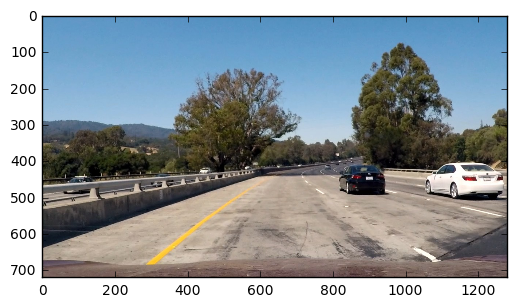

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline  
M, Minv = compute_M_Minv()
img = mpimg.imread('test_images/test1.jpg')
plt.imshow(img)


Test thresholding. 

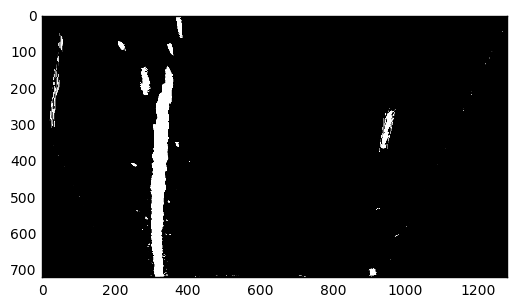

In [8]:
warped = thresholding(img, M)
plt.imshow(warped, cmap = 'gray')

Define the functions to find the lane pixels and drawing curvature and vehicle position and draw back to the original
images. 

lane_finding.py

In [10]:
def lane_finding(warped):
    '''
    This is used to find all lane line pixels.
    :param warped:
    :return:
    '''
    lefty, leftx, righty, rightx = [], [], [], []

    #slide window size
    window_height = 100
    window_width_half = 60

    #the bottom half
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    peak_left = np.argmax(histogram[:warped.shape[1]//2])
    peak_right = np.argmax(histogram[warped.shape[1]//2:]) + warped.shape[1]//2

    #Add some points to make the line more robust.
    for i in range(100):
        righty.append(720)
        rightx.append(peak_right)

    for offset in range(warped.shape[0],-1, -window_height):
        if offset - window_height < 0:
            start = 0
        else:
            start = offset - window_height

        for y in range(start, offset):
            for x in range(peak_left - window_width_half, peak_left + window_width_half + 1):
                if warped[y, x] == 1:
                    leftx.append(x)
                    lefty.append(y)

            for x in range(peak_right - window_width_half, peak_right + window_width_half + 1):
                if warped[y, x] == 1:
                    rightx.append(x)
                    righty.append(y)

        histogram_left = np.sum(warped[start:offset, peak_left - window_width_half:peak_left + window_width_half + 1], axis=0)
        histogram_right = np.sum(warped[start:offset, peak_right - window_width_half:peak_right + window_width_half + 1], axis=0)

        try:
            if histogram_left.max() > 5:
                peak_left = np.argmax(histogram_left) + peak_left - window_width_half
        except:
            pass

        try:
            if histogram_right.max() > 5:
                peak_right = np.argmax(histogram_right) + peak_right - window_width_half
        except:
            pass

    return np.array(leftx),np.array(lefty),np.array(rightx),np.array(righty)


def get_curvature(left_fitx, right_fitx, yvals):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meteres per pixel in x dimension
    y_eval = 720
    left_fit_cr = np.polyfit(yvals * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(yvals * ym_per_pix, right_fitx * xm_per_pix, 2)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval + left_fit_cr[1]) ** 2) ** 1.5) \
                    / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval + right_fit_cr[1]) ** 2) ** 1.5) \
                     / np.absolute(2 * right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad


def get_polyfit(leftx, lefty, yvals, lleftfit = None, llleftfit = None):
    left_fit = np.polyfit(lefty, leftx, 2)
    if lleftfit != None:
        if llleftfit != None:
            left_fit = 0.4*left_fit + 0.4*lleftfit + 0.2*llleftfit
        else:
            left_fit = (left_fit + lleftfit)/2
    left_fitx = left_fit[0] * yvals ** 2 + left_fit[1] * yvals + left_fit[2]
    return left_fitx, left_fit


def vehicle_position(left_fitx, right_fitx):
    xm_per_pix = 3.7 / 700  # meteres per pixel in x dimension
    val_center = (left_fitx[-1] + right_fitx[-1])/2
    return (1280/2 - val_center) * xm_per_pix


def draw_back(warped, img, left_fitx, right_fitx, yvals, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

Find the lane line pixels, and draw back onto the original images. The curvature and lane deviation are also shown in
the image. 

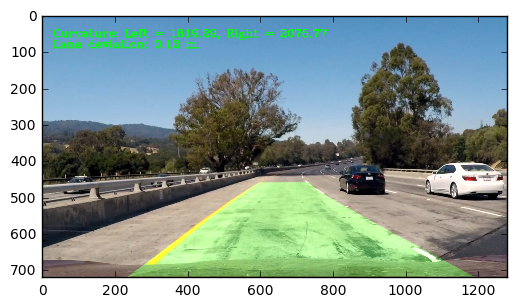

In [11]:
leftx, lefty, rightx, righty = lane_finding(warped)

yvals = np.linspace(0, 100, num=101) * 7.2
left_fitx, left_fit = get_polyfit(leftx, lefty, yvals)
right_fitx, right_fit = get_polyfit(rightx, righty,yvals)
left_curverad, right_curverad = get_curvature(left_fitx, right_fitx, yvals)

ve_position = vehicle_position(left_fitx, right_fitx)
ve_position = 'Lane deviation: ' + str(np.around(ve_position, 2)) + ' m.'

str_curv = 'Curvature: Left = ' + str(np.around(left_curverad, 2)) + ', Right = ' + str(np.around(right_curverad, 2))
font = cv2.FONT_HERSHEY_COMPLEX
result = draw_back(warped, img, left_fitx, right_fitx, yvals, Minv)
cv2.putText(result, str_curv, (30, 60), font, 1, (0, 255, 0), 2)
cv2.putText(result, ve_position, (30, 90), font, 1, (0, 255, 0), 2)

plt.imshow(result)

# Test on the video. 
Defind the pipeline to process video. Note that Line() class is used to store the recent fits. When we are confident
about our finding in the last frame, we can only search around the line center in the last frame. 

In [12]:
from moviepy.editor import VideoFileClip

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #last frame detected
        self.detected = False

        #line range in last frame
        self.recent_leftrange = [0, 0]
        self.recent_rightrange = [0, 0]

        self.left_fit = None
        self.right_fit = None

        self.left_fit2 = None
        self.right_fit2 = None

    def update_fit(self, leftfit, rightfit):
        self.left_fit2 = self.left_fit
        self.right_fit2 = self.right_fit
        self.left_fit = leftfit
        self.right_fit = rightfit
line = Line()

M, Minv = compute_M_Minv()
yvals = np.linspace(0, 100, num=101) * 7.2


def process_image(img):

    global line, count1, count2, count, M, Minv, yvals

    if line.detected == True:
        #there is line detected in the last frame
        warped = thresholding2(img, line.recent_leftrange, line.recent_rightrange, M)
        leftx, lefty, rightx, righty = lane_finding(warped)
        left_fitx, left_fit = get_polyfit(leftx, lefty, yvals, line.left_fit, line.left_fit2)
        right_fitx, right_fit = get_polyfit(rightx, righty, yvals, line.right_fit, line.right_fit2)
        if 0.85 < (left_fitx[-1] - right_fitx[-1])/((left_fitx[1] - right_fitx[1])) < 1.15:
            pass
        else:
            warped = thresholding(img, M)
            leftx, lefty, rightx, righty = lane_finding(warped)
            left_fitx, left_fit = get_polyfit(leftx, lefty, yvals, line.left_fit, line.left_fit2)
            right_fitx, right_fit = get_polyfit(rightx, righty, yvals, line.right_fit, line.right_fit2)

    else:
        warped = thresholding(img, M)
        leftx, lefty, rightx, righty = lane_finding(warped)
        left_fitx, left_fit = get_polyfit(leftx, lefty, yvals, line.left_fit, line.left_fit2)
        right_fitx, right_fit = get_polyfit(rightx, righty, yvals, line.right_fit, line.right_fit2)
        line.detected = True

    line.recent_leftrange = [left_fitx.min(), left_fitx.max()]
    line.recent_rightrange = [right_fitx.min(), right_fitx.max()]

    line.update_fit(left_fit,right_fit)

    left_curverad, right_curverad = get_curvature(left_fitx, right_fitx, yvals)
    ve_position = vehicle_position(left_fitx, right_fitx)
    ve_position = 'Lane deviation: ' + str(np.around(ve_position, 2)) + ' m.'

    str_curv = 'Curvature: Left = ' + str(np.around(left_curverad, 2)) + ', Right = ' + str(np.around(right_curverad, 2))
    font = cv2.FONT_HERSHEY_COMPLEX
    result = draw_back(warped, img, left_fitx, right_fitx, yvals, Minv)
    cv2.putText(result, str_curv, (30, 60), font, 1, (0, 255, 0), 2)
    cv2.putText(result, ve_position, (30, 90), font, 1, (0, 255, 0), 2)
    return result

Test on 'project_video.mp4'. 

In [13]:
white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:47<00:00,  5.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



I have enjoyed doing this project, and learnt a lot from it. Now, the pipeline can work on 'project_video.mp4' very well. However, it still need more improments if applied on the more challenging video. I will try to improve it afterward. 